In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from keras.utils import plot_model

In [4]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
train = get_training_data('/content/drive/MyDrive/Colab Notebooks/DL/test/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/Colab Notebooks/DL/test/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/Colab Notebooks/DL/test/chest_xray/val')

<ipython-input-4-6c10612e3c9d>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# Normalize the data

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
# resize
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

img_data_gen = ImageDataGenerator(
        featurewise_center=False,  # 데이터셋 전체의 평균을 0으로 만들기 위해 feature-wise centering을 사용할 것인지 여부
        samplewise_center=False,  # 샘플별로 평균을 0으로 만들기 위해 sample-wise centering을 사용할 것인지 여부
        featurewise_std_normalization=False,  # 데이터셋 전체의 표준편차로 각 feature를 scaling할 것인지 여부
        samplewise_std_normalization=False,  # 샘플별로 표준편차로 각 feature를 scaling할 것인지 여부
        zca_whitening=False,  # ZCA Whitening 적용 여부
        rotation_range = 45,  # 이미지 회전 각도 범위 (0 ~ 지정된 값 사이에서 무작위로 회전)
        width_shift_range=0.1,  # 이미지 가로 방향으로 평행 이동할 픽셀 크기 범위 (지정된 값의 범위에서 무작위 이동)
        height_shift_range=0.1,  # 이미지 세로 방향으로 평행 이동할 픽셀 크기 범위 (지정된 값의 범위에서 무작위 이동)
        horizontal_flip = True,  # 수평으로 무작위로 뒤집을지 여부
        vertical_flip=True)  # 수직으로 무작위로 뒤집을지 여부


img_data_gen.fit(x_train)

In [10]:
# img_data_gen =ImageDataGenerator(
#     featurewise_center=False,             # 데이터셋 전체의 평균을 0으로 만들기 위해 feature-wise centering을 사용할 것인지 여부
#     samplewise_center=False,              # 샘플별로 평균을 0으로 만들기 위해 sample-wise centering을 사용할 것인지 여부
#     featurewise_std_normalization=False,  # 데이터셋 전체의 표준편차로 각 feature를 scaling할 것인지 여부
#     samplewise_std_normalization=False,   # 샘플별로 표준편차로 각 feature를 scaling할 것인지 여부
#     zca_whitening=False,                  # ZCA Whitening 적용 여부
#     rotation_range=0,                     # 이미지 회전 각도 범위 (0 ~ 지정된 값 사이에서 무작위로 회전)
#     zoom_range=0,                         # 이미지 축소/확대 범위 (1-지정된 값 ~ 1+지정된 값 사이에서 무작위로 축소/확대)
#     width_shift_range=0,                  # 이미지 가로 방향으로 평행 이동할 픽셀 크기 범위 (지정된 값의 범위에서 무작위 이동)
#     height_shift_range=0,                 # 이미지 세로 방향으로 평행 이동할 픽셀 크기 범위 (지정된 값의 범위에서 무작위 이동)
#     horizontal_flip=True,                 # 수평으로 무작위로 뒤집을지 여부
#     vertical_flip=False,                  # 수직으로 무작위로 뒤집을지 여부    
#     zca_epsilon=1e-6,                     # ZCA Whitening 시 0으로 나누기를 피하기 위해 더해줄 작은 값을 지정
#     brightness_range=None,                # 이미지 밝기 조절 범위 (tuple 형태로 지정하여 범위 지정 가능)
#     shear_range=0.0,                      # 이미지 전단 강도 범위 (0 ~ 지정된 값 사이에서 무작위로 전단 변환)
#     channel_shift_range=0.0,              # 이미지 색상 채널 이동 범위 (지정된 값의 범위에서 무작위 색상 변환)
#     fill_mode='nearest',                  # 이미지 축소/확대 시 발생하는 빈 픽셀을 어떻게 채울지 결정하는 방법
#     cval=0.0,                             # fill_mode가 constant인 경우, 채울 값
#     rescale=None,                         # 이미지 픽셀 값을 0~1 사이 값으로 조정할지 여부
#     preprocessing_function=None,          # 이미지 전처리 함수 적용 여부
#     data_format=None,                     # 이미지 데이터의 형식 (channels_first 또는 channels_last)
#     validation_split=0.0,                 # Float. 0과 1 사이의 값으로, 데이터의 얼마나를 검증 데이터셋으로 사용할 것인지 비율을 지정
#     dtype=None)
# img_data_gen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

### 모델링

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

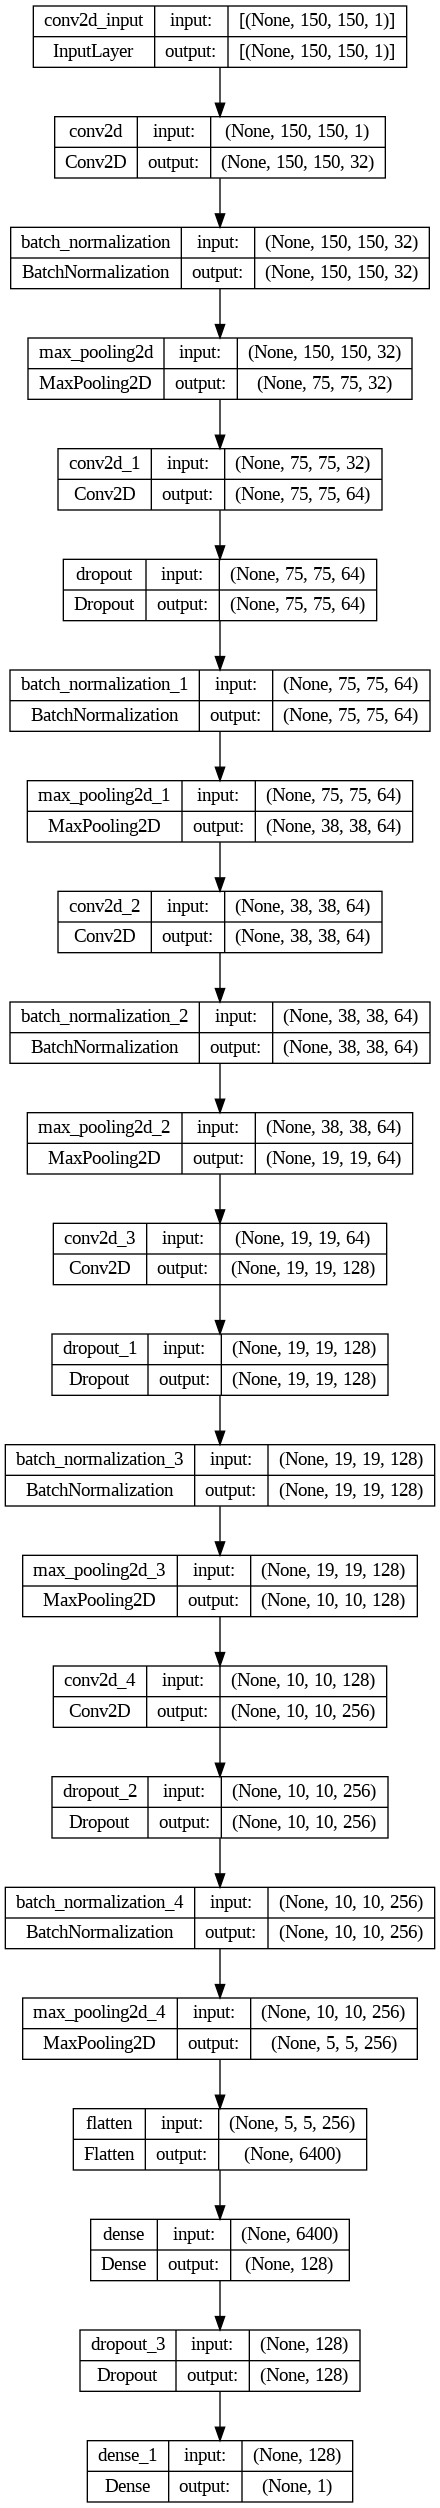

In [12]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [13]:
!pip install visualkeras

import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 54.2 MB/s eta 0:00:00


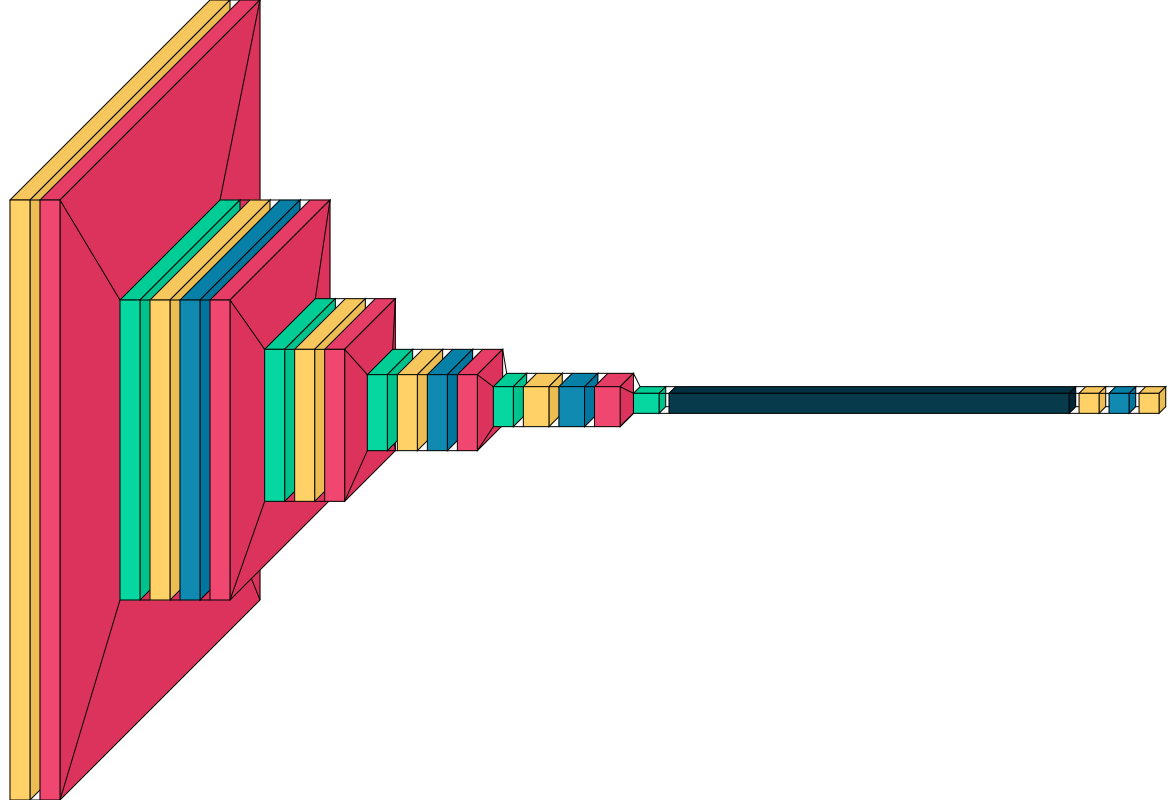

In [14]:
visualkeras.layered_view(model).show() 

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=1e-6)

In [20]:
history = model.fit(img_data_gen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 15, 
                    validation_data = img_data_gen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/15
163/163 [==============================] - 16s 95ms/step - loss: 0.1005 - accuracy: 0.9628 - val_loss: 2.4291 - val_accuracy: 0.5625 - lr: 9.0000e-05
Epoch 2/15
163/163 [==============================] - 14s 83ms/step - loss: 0.0926 - accuracy: 0.9659 - val_loss: 5.9240 - val_accuracy: 0.5625 - lr: 9.0000e-05
Epoch 3/15
163/163 [==============================] - 14s 83ms/step - loss: 0.0936 - accuracy: 0.9676 - val_loss: 0.4478 - val_accuracy: 0.7500 - lr: 9.0000e-05
Epoch 4/15
163/163 [==============================] - 14s 85ms/step - loss: 0.0986 - accuracy: 0.9688 - val_loss: 0.4856 - val_accuracy: 0.8750 - lr: 9.0000e-05
Epoch 5/15
163/163 [==============================] - 14s 84ms/step - loss: 0.0850 - accuracy: 0.9701 - val_loss: 2.9132 - val_accuracy: 0.5625 - lr: 9.0000e-05
Epoch 6/15
163/163 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.9718
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
163/163 [==============

In [25]:
print("모델 Loss - " , model.evaluate(x_test,y_test)[0])
print("정확도 Accuracy - " , model.evaluate(x_test,y_test)[1])

20/20 [==============================] - 0s 14ms/step - loss: 0.4194 - accuracy: 0.9006
모델 Loss -  0.41936400532722473
20/20 [==============================] - 0s 10ms/step - loss: 0.4194 - accuracy: 0.9006
정확도 Accuracy -  0.9006410241127014


### 모델 시각화

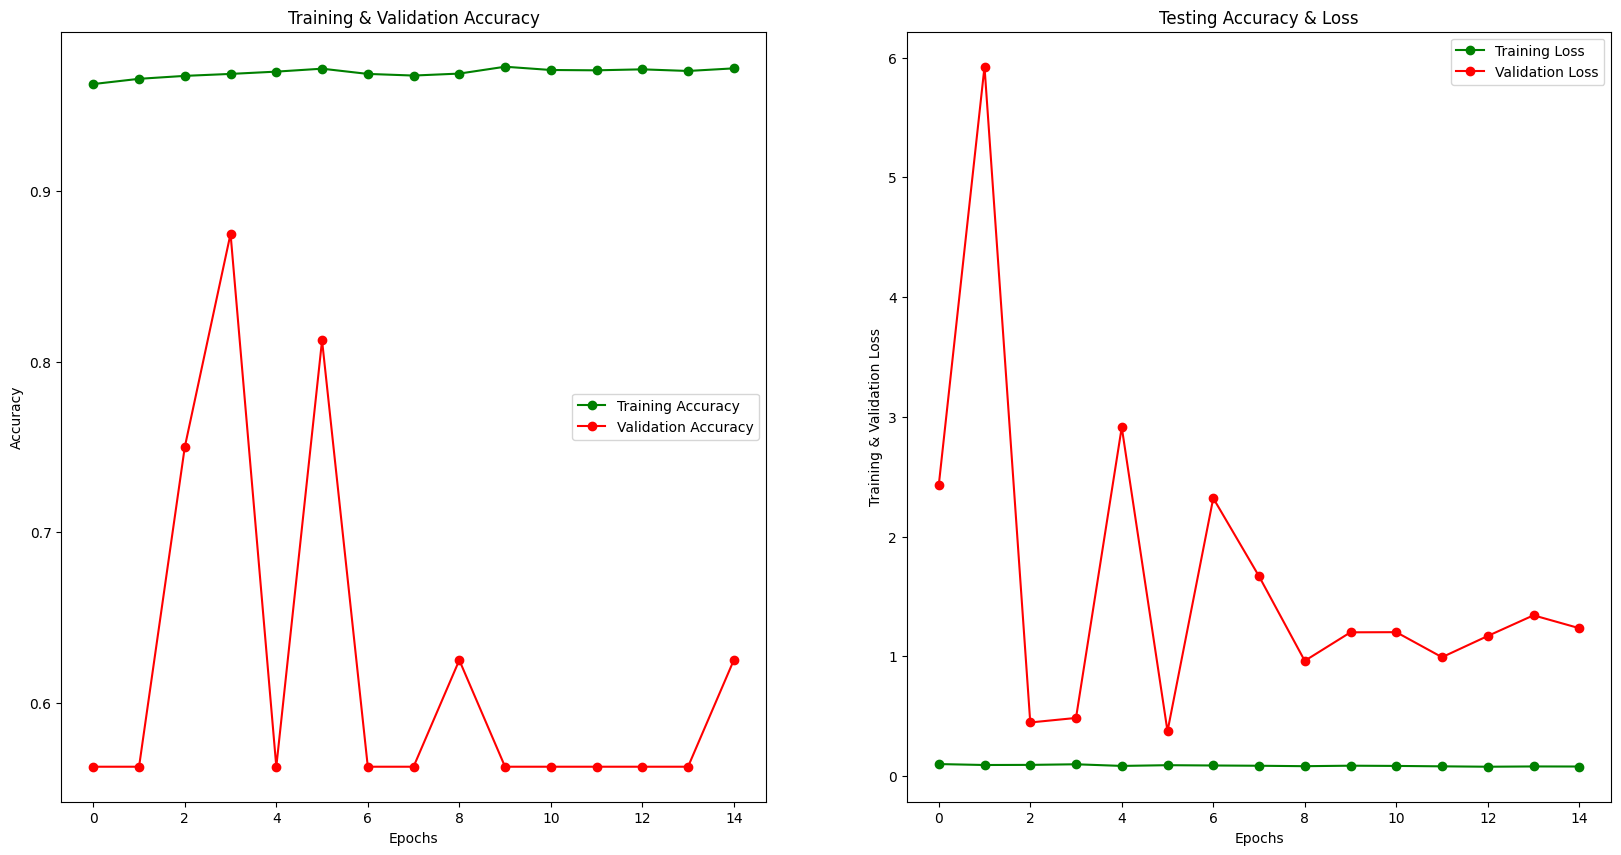

In [24]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()